# Import Libraries / Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, Reshape, dot, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam#, SGD, RMSprop, Adadelta, Adamax, Adagrad
from tensorflow.keras.losses import mean_squared_error as mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import tensorflow_hub as hub

from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel, AutoConfig

import torch

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import visualkeras

pd.options.display.max_colwidth = 200

/Users/benjaminpoh/opt/anaconda3/envs/tensordsi24/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#df_coffee = pd.read_csv('cleaned_coffees.csv')

In [3]:
df_sweetmarias = pd.read_csv('cleaned_sweetmarias.csv')

In [4]:
df_sweetmarias.fillna('', inplace=True)

# Brief Introduction

For Part 2, the aim is to leverage the text data from the OCR tool to generate recommendations of related coffees to buy from Sweet Marias. For example, if the OCR tool generates these words `['plum, berry, caturra, washed']`, we should ideally get recommendations on 5 coffees with very similar descriptions from Sweet Marias. 

There are a few different NLP/deep-learning methods that I will try out in this section. These are a **baseline TF-IDF model**, a **feed-forward neural network auto-encoder**, a **Word2Vec model** and a **BERT transformer**.

This is content-based recommendater system and recommendations are ranked based on the cosine distance of the word vectors generated from the 'query' (OCR text) and each coffee description from Sweet Marias.

## Dataset

The dataset is pull from Sweet Marias' website with the web-scraping notebook. It consists of 341 different coffee data scraped from SweetMarias in the 1st week of November 2021. The scraped data includes information such as country, region/farm, description of tasting notes, processing method and bean variety. For this project, I have chosen to combine *description*, *processing method* and *variety* as the 'document' for each coffee. Collectively, these 341 documents make up the corpus for this project. 

I have decided to exclude country and region/farm in the document because one of the intentions of the recommender system is to propose coffees based on the taste profile of the bean. For example, if the country 'Colombia' is part of the query sentence, having country names in each document will likely result in mostly Colombian coffees being the top 5 recommendations - while this might be perfect for someone looking for Colombian coffees, the intention of this recommender system is to prioritise tasting notes instead of country similarity.

# Pre-processing & EDA

## Pre-processing

In terms of pre-processing, there are a few basic text cleaning steps (lowercase text, removing \n etc.) followed by simple tokenization (with the option of lemmatization). Tokenization will not apply to the BERT model as it has its own in-built tokenization process in the architecture offered by SentenceTransformers.

In [82]:
#Stopwords to exclude

new_stop_words = ['coffee','bean','beans','roaster','roasters','process','variety']
total_stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [107]:
def clean_text(text):
    '''Function to apply basic cleaning'''
    
    stopwords=total_stop_words
    text = text.lower() #lowercase all text
    text = re.sub(r'(\r\n|\r|\n)',' ',text) #remove \r and \n
    text = re.sub(r'[^\w\s]',' ',text) #remove all non-alphanumeric characters
    
    text = [i for i in text.split() if i not in stopwords]
    text = tokens = ', '.join(text)
    return text

In [84]:
def tokenizer(document, stopwords=total_stop_words, lemmatize=True):
    '''Function to tokenize words with option to apply lemmatization'''
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        
        tokens = [lemmatizer.lemmatize(i) for i in word_tokenize(document)]
    else:
        tokens = [i for i in word_tokenize(document)]
    
    tokens = [i for i in tokens if i not in stopwords]
    
    
    return tokens

In [85]:
df_sweetmarias['cleaned_combined'] = df_sweetmarias['exlc_name_combined'].apply(clean_text)

In [86]:
df_sweetmarias['tok_lem_combined'] = df_sweetmarias['cleaned_combined'].apply(lambda x: tokenizer(x, stopwords=total_stop_words, lemmatize=False))

In [10]:
#df_coffee['cleaned_combined'] = df_coffee['exlc_name_combined'].apply(clean_text)

In [11]:
#df_coffee['tok_lem_combined'] = df_coffee['cleaned_combined'].apply(lambda x: tokenizer(x, stopwords=total_stop_words, lemmatize=True))

In [12]:
#df_sweetmarias['tfidf_combined'] = df_sweetmarias['cleaned_combined'].apply(lambda x: tokenizer2(x, stopwords=total_stop_words, lemmatize=True))

## EDA

**Average length of sentence**

In [87]:
doc_length = []
for document in range(len(df_sweetmarias['tok_lem_combined'])):
    doc_length.append(len(df_sweetmarias['tok_lem_combined'][document]))

avg_doc_length = sum(doc_length)/len(doc_length)
print(f'{round(avg_doc_length)}' + ' words')

27 words


**Most Common Words**

In [88]:
words = []
for document in range(len(df_sweetmarias['tok_lem_combined'])):
    for word in df_sweetmarias['tok_lem_combined'][document]:
        words.append(word)
        
words = pd.DataFrame(words)
words.value_counts().head(15)

city         724
wet          253
washed       248
bourbon      175
espresso     172
sweetness    167
good         164
notes        151
chocolate    136
sugar        132
hybrids      128
modern       128
flavors      112
acidity      105
tea          104
dtype: int64

# Query

**Placeholder for now** - this will be linked with OCR text data from Part 1

In [111]:
query = 'plum, berry, caturra, washed, roaster'

# TF-IDF (Baseline)

Term Frequency Inverse Document Frequency (TF-IDF) is one of the easiest and fastest ways to analyse the relevance of a term (word) in a given document. It gives a numerical weightage of words (to reflect its importance in the document), and weighs down the frequently occurings words to identify the difference between one document and another. However, as a simple model, it does not understand semantics, synonyms or other nuances in language.

We will be using the TF-IDF as a baseline model to compare against the other more complex models. As much as it is a corpus exploration method, TF-IDF is also used as a pre-processing step for other models. Therefore, we will also be using the TF-IDF matrix as a pre-processed input for the auto-encoder model that I've built in the later section.

In [110]:
def recommend_coffee_from_description_tfidf(query, model_embed):
    '''Function to calculate cosine similarity and return top 5 recommendations'''
    
    #Embed query
    clean_query = clean_text(query)
    vectorize_query = tfidf.transform([clean_query]) #apply tfidf transform on query
    
    #Matrix of similarity between query and database
    similarity_matrix = pd.DataFrame(cosine_similarity(vectorize_query, model_embed))
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [92]:
#Creating the documents from the 'tok_lem_combined' column from the pre-processing step

df_sweetmarias['tfidf_lem_combined'] = df_sweetmarias['tok_lem_combined'].apply(lambda x: ' '.join(x))

In [93]:
#sklearn's TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=total_stop_words, binary=True)
tfidf_matrix = tfidf.fit_transform(df_sweetmarias['tfidf_lem_combined'].values)

In [94]:
tfidf_matrix_array = tfidf_matrix.toarray()

In [157]:
#Top 5 recommended coffees

recommend_coffee_from_description_tfidf(query, tfidf_matrix_array)

,Name,Description,Process,Variety,similarity_score
16,Congo Kivu Kalehe Cooperative,"Sweet, spiced and with tangy citrus accents, flavor notes of orange, cardamom pod and clove, marmalade spread, and the acidic impression is grabby like grapefruit. City to Full City.",Wet Washed,Bourbon,0.274346
308,Colombia Honey Process Nariño Aponte,"The flavor profile opens up to molasses cookie, cinnamon hint, an array of dried fruited accents like date and fig, and an opaque chocolatey side in the middle/dark roasts. City+ to Full City+. Go...",Honey,"Caturra, Typica",0.180084
57,Kenya Embu Gakui Peaberry,"Gakui's flavor profile is enlivened with fruit and spice notes like dried plum, date pieces, cinnamon stick, all spice powder, plum tea, tea-like tannic acidity, and some grapefruit bittering that...",Wet Washed,Bourbon,0.173444
160,Guatemala Antigua Finca Cabrejo,"Bodied, incredible balance, sugar cane juice sweetness, top notes of oatmeal cookie, dried fig, raisin, lemon tea note that adds vibrance. Chocolatey dark roasts too. City to Full City. Good for e...",Wet Washed,Bourbon,0.172958
113,Rwanda Rulindo Tumba,"Torched sugar with accents of red berry, fig, and tamarind hard candy. Spiced chocolate and dried date when roasted dark, and heavy body like soy milk. City to Full City. Good for espresso.",Wet Washed,Bourbon,0.172157


# Auto-Encoder

An auto-encoder is an unsupervised neural network that learns how to efficiently compress and encode data, and then learns how to reconstruct this data back from the its reduced encoded form to one that is as close to the original input as possible. The aim is to minimise the reconstruction error (the difference between original input and reconstruction) via back progation during the training process. By 'compressing' the input, we are forcing the model to learn useful information by filtering out noise from the data. The output for the model is at the 'compressed' layer called the bottleneck, and this is where we extract the information for predictions later on. Background details are from [here](https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726) and [here](https://machinelearningmastery.com/autoencoder-for-classification/).

Auto-encoders can be deployed using different architectures - feed-forward network, LTSM, CNN etc. For this project, I have trained a simple feed-forward network of 6 layers as a comparison to see how effective it is versus other state of the art architectures. While auto-encoders are usually used for image classification problems, there are several research papers exploring its use in the semantic text similarity space (e.g. [Amiri et al., 2016](https://scholar.harvard.edu/files/hadi/files/amiri-acl-16.pdf) and [Mandic, 2018](https://helda.helsinki.fi/bitstream/handle/10138/273571/grappa_files_17_08_2018.pdf?sequence=2&isAllowed=y)). For semantic text similarity problems, the idea is that if a model is able to provide a good reconstruction of the input (in this case, the documents in the corpus), it should have retained the good information (what's different/similar) of the input, and therefore have become a context-sensitive representation of the data.

In my model, I have added dropout layers to prevent overfitting since the dataset that I have used is relatively small.

In [230]:
def recommend_coffee_from_description_ae(query, auto_encode_embedding):
    
    #Embed query
    clean_query = clean_text(query)
    vectorize_query = tfidf.transform([clean_query]) #apply tfidf transform on query
    
    #Predict
    query_predict = embedding.predict(vectorize_query)
    
    #Matrix of similarity between query and database
    similarity_matrix = pd.DataFrame(cosine_similarity(
            query_predict,auto_encode_embedding))
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [231]:
tf.random.set_seed(42)
input_size = tfidf_matrix_array.shape[1]
intermediate_size = 512
intermediate_2_size =256
code_size = 48

def auto_encoder():
    
    #Encode
    model = Sequential()
    model.add(Dense(intermediate_size,input_shape=(input_size,))) 
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_encoder1'))
    model.add(Activation('relu'))
    
    
    model.add(Dense(intermediate_2_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_encoder2'))
    model.add(Activation('relu'))
    
    #bottleneck
    model.add(Dense(code_size))
    model.add(Activation('relu', name='bottleneck'))
    
    #Decode
    model.add(Dense(intermediate_2_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_decoder1'))
    model.add(Activation('relu'))
    
    
    model.add(Dense(intermediate_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_decoder2'))
    model.add(Activation('relu'))
    
    model.add(Dense(input_size,))
    model.add(Activation('sigmoid'))
    return model

In [232]:
auto_encode = auto_encoder() 

In [233]:
auto_encode.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               595968    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
bn_encoder1 (BatchNormalizat (None, 512)               2048      
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
bn_encoder2 (BatchNormalizat (None, 256)              

In [234]:
train, test = train_test_split(tfidf_matrix_array, random_state=42)

In [235]:
checkpoint_path = "autoencoder_cp.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   verbose=1)

callback_list = [model_checkpoint]

auto_encode.compile(optimizer='Adam', loss='mse')
history = auto_encode.fit(train, train, #train, train because targets of the autoencoder are the same as the input
                          epochs = 70,
                          batch_size = 64,
                          shuffle = True,
                          validation_data = (test, test),
                          callbacks=callback_list,
                          verbose = 1)


Train on 258 samples, validate on 86 samples
Epoch 1/70
192/258 [=====================>........] - ETA: 0s - loss: 0.2211
Epoch 00001: val_loss improved from inf to 0.24140, saving model to autoencoder_cp.h5
258/258 [==============================] - 3s 13ms/sample - loss: 0.2013 - val_loss: 0.2414
Epoch 2/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0710
Epoch 00002: val_loss improved from 0.24140 to 0.22462, saving model to autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 0.0631 - val_loss: 0.2246
Epoch 3/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0191
Epoch 00003: val_loss improved from 0.22462 to 0.19678, saving model to autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 0.0172 - val_loss: 0.1968
Epoch 4/70
192/258 [=====================>........] - ETA: 0s - loss: 0.0065
Epoch 00004: val_loss improved from 0.19678 to 0.16314, saving model to autoencoder_cp.h5
258/258 [========

192/258 [=====================>........] - ETA: 0s - loss: 9.5495e-04
Epoch 00032: val_loss improved from 0.00186 to 0.00180, saving model to autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 9.5593e-04 - val_loss: 0.0018
Epoch 33/70
192/258 [=====================>........] - ETA: 0s - loss: 9.6126e-04
Epoch 00033: val_loss improved from 0.00180 to 0.00174, saving model to autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 9.5992e-04 - val_loss: 0.0017
Epoch 34/70
192/258 [=====================>........] - ETA: 0s - loss: 9.5109e-04
Epoch 00034: val_loss improved from 0.00174 to 0.00168, saving model to autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 9.4886e-04 - val_loss: 0.0017
Epoch 35/70
192/258 [=====================>........] - ETA: 0s - loss: 9.4501e-04
Epoch 00035: val_loss improved from 0.00168 to 0.00163, saving model to autoencoder_cp.h5
258/258 [==============================

Epoch 63/70
192/258 [=====================>........] - ETA: 0s - loss: 8.7083e-04
Epoch 00063: val_loss improved from 0.00118 to 0.00117, saving model to autoencoder_cp.h5
258/258 [==============================] - 0s 1ms/sample - loss: 8.7044e-04 - val_loss: 0.0012
Epoch 64/70
192/258 [=====================>........] - ETA: 0s - loss: 8.7373e-04
Epoch 00064: val_loss did not improve from 0.00117
258/258 [==============================] - 0s 1ms/sample - loss: 8.7132e-04 - val_loss: 0.0012
Epoch 65/70
192/258 [=====================>........] - ETA: 0s - loss: 8.7018e-04
Epoch 00065: val_loss did not improve from 0.00117
258/258 [==============================] - 0s 979us/sample - loss: 8.6831e-04 - val_loss: 0.0012
Epoch 66/70
192/258 [=====================>........] - ETA: 0s - loss: 8.6956e-04
Epoch 00066: val_loss did not improve from 0.00117
258/258 [==============================] - 0s 1ms/sample - loss: 8.6857e-04 - val_loss: 0.0012
Epoch 67/70
192/258 [=====================>....

In [236]:
auto_encode.save('auto_encode_model.h5')

In [237]:
train_loss = history.history["loss"]
test_loss = history.history['val_loss']
epoch_labels = history.epoch

losses = pd.DataFrame(data=list(zip(train_loss, test_loss)), columns=['train_loss', 'validation_loss'])

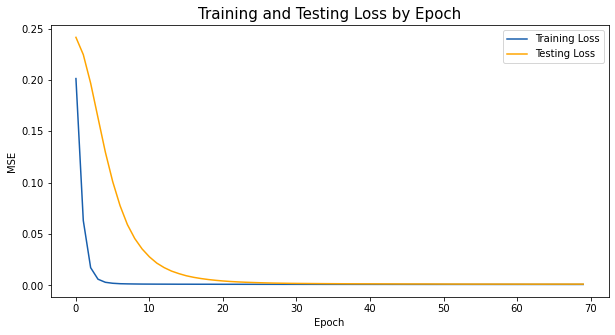

In [238]:
plt.figure(figsize=(10, 5))

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('MSE', fontsize = 10)
plt.legend(fontsize = 10);


In [239]:
embedding = Model(auto_encode.inputs, auto_encode.get_layer('bottleneck').output)
auto_encode_embedding = embedding.predict(tfidf_matrix_array)

In [240]:
recommend_coffee_from_description_ae(query, auto_encode_embedding)

,Name,Description,Process,Variety,similarity_score
19,Ethiopia Dry Process Bogale Deyaso,"Rustic fruit flavors, molasses sugars, fragrant foresty accents, notes of dehydrated apricot, prune, and tamarind, aromatic cedar, and bittersweet bass notes. City+ to Full City+.",Dry Natural,Heirloom,0.915651
46,Ethiopia Organic Nensebo Refisa,"An aromatic cup in all of our roasts, dried florals, sweet herbs, and fragrant woody incense, notes of simple syrup, orange essence, fruit gum, and grabby citrus finish. City to Full City.",Wet Washed,Heirloom,0.904152
326,Colombia Urrao Heirloom Caturra,"The patient drinker will be rewarded, top notes flourish as the cup cools, dark stone fruit, berry, baking spices, brisk, black tea, atop a grounding brown sugar sweetness and Root Beer finishing ...",Wet Washed,"Caturra, Heirloom",0.894194
148,El Salvador Matalapa Calagual,"A well-balanced, big-bodied coffee that's infinitely drinkable. Caramel sweetness, moderate chocolate roast flavors, dried apple, creamy macadamia nut. City+ to Full City+. Good for espresso.",Wet Washed,Bourbon,0.892364
130,Yemen Sana'a-Ibb Highlands,"Resonant bittersweetness, creamy body, baking chocolate and high % cacao, top notes of pumpkin seed, anise, aromatic wood, dried apricot, dusty cocoa powder, and more. City+ to Vienna. Fantastic e...",Dry Natural,Heirloom,0.883968


In [35]:
# tf.random.set_seed(42)
# input_size = tfidf_matrix_array.shape[1]
# intermediate_size = 512
# intermediate_2_size =256
# code_size = 64

# def auto_encoder1():
    
#     #Encode
#     model = Sequential()
#     model.add(Dense(intermediate_size,input_shape=(input_size,))) 
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization(axis=1, name='bn_encoder1'))
#     model.add(Activation('relu'))
    
    
#     #bottleneck
#     model.add(Dense(code_size))
#     model.add(Activation('relu', name='bottleneck'))

#     #Decode
#     model.add(Dense(intermediate_size))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization(axis=1, name='bn_decoder2'))
#     model.add(Activation('relu'))
    
#     model.add(Dense(input_size,))
#     model.add(Activation('sigmoid'))
#     return model

In [36]:
# auto_encode1 = auto_encoder1() 
# auto_encode1.summary()

In [216]:
# checkpoint_path = "autoencoder_cp1.h5"

# model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
#                                    monitor='val_loss',
#                                    save_best_only=True,
#                                    mode='min',
#                                    verbose=1)

# callback_list = [model_checkpoint]

# auto_encode1.compile(optimizer='Adam', loss='mse')
# history = auto_encode1.fit(train, train, #train, train because targets of the autoencoder are the same as the input
#                           epochs = 110,
#                           batch_size = 64,
#                           shuffle = True,
#                           validation_data = (test, test),
#                           callbacks=callback_list,
#                           verbose = 1)

In [39]:
# embedding1 = Model(auto_encode1.inputs, auto_encode1.get_layer('bottleneck').output)
# auto_encode1_embedding = embedding1.predict(tfidf_matrix_array)

In [217]:
# recommend_coffee_from_description_ae1(query1, auto_encode1_embedding)

In [ ]:
# def recommend_coffee_from_description_ae1(query, auto_encode_embedding):
    
#     #Embed query
#     clean_query = clean_text(query)
#     vectorize_query = tfidf.transform([clean_query]) #apply tfidf transform on query
    
#     #Predict
#     query_predict = embedding1.predict(vectorize_query)
    
#     #Matrix of similarity between query and database
#     similarity_matrix = pd.DataFrame(cosine_similarity(
#             query_predict,auto_encode_embedding))
    
#     #New column of 'similarity_score'
#     similar_items = pd.DataFrame(similarity_matrix.T)
#     similar_items.columns = ["similarity_score"]
#     similar_items = similar_items.sort_values('similarity_score', ascending=False)
#     similar_items.reset_index(inplace=True)
    
#     #Use index as an 'item_id' 
#     similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
#     similar_coffees = pd.DataFrame(similar_items.to_dict())
#     similar_coffees.set_index('item_id', inplace=True)
    
#     #List top recommendations 
#     similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
#     similar_df.sort_values('similarity_score', ascending=False, inplace=True)
#     return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

# Word2Vec

Word2Vec is a popular word embedding technique used to learn the semantics of the words in a corpus. Like an auto-encoder, it encodes each word in a vector. However, instead of training the input words through the reconstruction process (encode/decode), Word2Vec trains words against those that are near to them in the vector space. It achieves this in two ways: continuous bag of words (CBOW) or skip-gram. I have chosen the latter for this project because it tends to perform better on smaller datasets and represents rare words well [Source](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

However, one key downside to note about Word2Vec is that it cannot produce vectors for words that were not in the original dataset used for training. While there are more advanced methods to deal with unseen data (such as Facebook's FastText which builds vectors from root words), I have decided to simply exclude any unseen words if they occur in the query sentence.

For this project, I have chosen to train the model using Gensim's implementation of Word2Vec. These are the parameters I have adjusted for the model:
- min_count = 0 (low since we are using a small dataset)
- window = 2 (number of neighbouring words to affect the vector calculations)
- vector_size = 100
- alpha = 0.01 (learning rate)
- min_alpha = 0.0007 (min value at which learning rate will decrease linearly)
- sg = 1 (skip gram selected)


In [41]:
def is_word_in_model(word, model):
    """Check if word is in the corpus from the trained model"""
    assert type(model).__name__ == 'KeyedVectors'
    is_in_vocab = word in model.key_to_index.keys()
    return is_in_vocab

def recommend_coffee_from_description_w2v(query, dataset, model):
    query = query.split(', ')
    in_vocab_list, best_index = [], [0]*5
    for w in query:
        #Remove unseen words from query sentence
        if is_word_in_model(w, w2v_model.wv):
            in_vocab_list.append(w)

    #Find similarity between query and dataset
    if len(in_vocab_list) > 0:
        similarity_matrix = np.zeros(len(df_sweetmarias['tok_lem_combined'].values))  # TO DO
        for i, data_sentence in enumerate(df_sweetmarias['tok_lem_combined'].values):
            if data_sentence:
                similar_sentence = w2v_model.wv.n_similarity(
                        in_vocab_list, data_sentence)
            else:
                sim_sentence = 0
            similarity_matrix[i] = np.array(similar_sentence)

    similarity_matrix = pd.DataFrame(similarity_matrix)
    similar_items = pd.DataFrame(similarity_matrix)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)

    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)

    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [42]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [43]:
w2v_model = Word2Vec(min_count=0,
                     window=2,
                     vector_size=100, 
                     alpha=0.01, 
                     min_alpha=0.0007, 
                     sg = 1) 

w2v_model.build_vocab(df_sweetmarias['tok_lem_combined'].values)
w2v_model.train(df_sweetmarias['tok_lem_combined'].values, total_examples=w2v_model.corpus_count, epochs=100, callbacks=[callback()],
                         compute_loss=True)

Loss after epoch 0: 72546.4765625
Loss after epoch 1: 72521.3984375
Loss after epoch 2: 72947.546875
Loss after epoch 3: 71633.390625
Loss after epoch 4: 68287.4375
Loss after epoch 5: 63365.5625
Loss after epoch 6: 58685.96875
Loss after epoch 7: 57731.96875
Loss after epoch 8: 55413.4375
Loss after epoch 9: 54852.6875
Loss after epoch 10: 53741.0
Loss after epoch 11: 51635.4375
Loss after epoch 12: 50904.8125
Loss after epoch 13: 49928.4375
Loss after epoch 14: 50120.625
Loss after epoch 15: 48507.5625
Loss after epoch 16: 48284.125
Loss after epoch 17: 47072.875
Loss after epoch 18: 46949.375
Loss after epoch 19: 46589.875
Loss after epoch 20: 45904.625
Loss after epoch 21: 45531.75
Loss after epoch 22: 45403.5
Loss after epoch 23: 45367.375
Loss after epoch 24: 45138.75
Loss after epoch 25: 45270.25
Loss after epoch 26: 45240.125
Loss after epoch 27: 44988.5
Loss after epoch 28: 45023.0
Loss after epoch 29: 44804.5
Loss after epoch 30: 44684.0
Loss after epoch 31: 45111.625
Loss af

(617408, 940500)

In [44]:
w2v_model.save('word2vec.model')

In [45]:
recommend_coffee_from_description_w2v(query, df_sweetmarias['tok_lem_combined'].values, w2v_model)

,Name,Description,Process,Variety,similarity_score
314,Colombia Inzá Rio Paez,"The fruited side of Rio Paez emerges as it cools, hints of cherry, cooked apple and a winey plum note. Pour overs are profusely sweet, with a tea-like aftertaste and tannic bittering in mouthfeel....",Wet Washed,"Caturra, Typica, Modern Hybrids",0.946367
303,Colombia Buesaco Alianza Granjeros,"A caramel-sweet overtone, aromatic butterscotch note, hints of apple, dried date and an herbal accent in the aftertaste. Acidic impression like brisk black tea when roasted light. City to Full Cit...",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.937452
195,Guatemala Xinabajul Producers,"Moderate sweetness and acidity, turbinado, demerara, raisin, brisk black tea. Dark roasts show bittersweet cacao and molasses with a hint of berry. City to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Modern Hybrids",0.934327
309,Colombia Ibagué Rio Combeima,"Delicious in the light to middle roasts, panela and molasses sweetness, winey apple and plum hints, a cinnamon note, tannic black tea and cranberry-like acidic impression. City to City+.",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.934299
190,Guatemala Xinabajul Evelio Villatoro,"Complex as it cools, underlying flavors are fruited with caramelized sugars, accents of brisk tea, cardamom, and a berry note that feeds into a blueberry-like acidic impression. Delicious! City to...",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.933386


# BERT

BERT is a langugage model that represents one of the most recent advances in NLP. It is a bi-directional transformer pre-trained useing both masked language modelling (MLM) and next sentence prediction (NSL) on a large corpus comprising of Toronto Book Corpus and Wikipedia. Compared to Word2Vec, what makes transformers such as BERT more powerful is the ability to encode context of a given word from preceding and succeeding words in the vector via its *attention mechanism*. This attention mechanism allows us to look at the totality of the a sentence and make connections between words and its relevant context - this is markedly different from and more complext than the simple feed-forward auto-encoder which I have built above as that treats each word as an input independent of each other. 

For this project, I have chosen to use a direct implementation of the BERT architecture from SentenceTransformers. More specifically, I have selected the *paraphrase-MiniLM-L6-v2* model from SentenceTransformers as it performs relatively fast and is pre-trained specifically for tasks such as clustering or semantic search (more details [here](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2)). 

In [46]:
def recommend_coffee_from_description_bert(query_embedding, corpus_embeddings):
    
    #Matrix of similarity between query and database
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    similarity_matrix = pd.DataFrame(cos_scores)
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [47]:
BERT_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
corpus_embeddings = BERT_model.encode(df_sweetmarias['cleaned_combined'].values, convert_to_tensor=True)

In [48]:
query_embedding = BERT_model.encode(query, convert_to_tensor=True)

In [49]:
recommend_coffee_from_description_bert(query_embedding, corpus_embeddings)

,Name,Description,Process,Variety,similarity_score
47,Ethiopia Organic Shakiso Kayon Mountain Farm,"Unrefined sugar sweetness is cut through by a rindy citrus flavor, fruited accent notes of orange and dried strawberry, aromatic herbals, Earl Grey and hibiscus teas, and a soft floral jasmine not...",Wet Washed,Heirloom,0.578062
64,Kenya Kiambu Fram Farm AB,"Intense fruited character as it cools, ripe blueberry, blackberry tea, zesty orange, plum, along with date sugar sweetness, and a mead/fermented honey accent that adds a complex wine note to the m...",Wet Washed,Bourbon,0.550324
84,Kenya Nyeri Gatugi AA,"Juicy fruited profile that unfolds to notes of ripe apricot and nectarine, black cherry, mixed berries, fruit jam, fresh plum and fig, with immense sweetness anchoring the cup. Very nice Kenyan co...",Wet Washed,Bourbon,0.542493
304,Colombia Caicedo Gustavo Rivera,"Subverts your expectations of what washed coffees can taste like, flavors touch on nectarine and peach, fermented raspberry, fruit preserves, tart blueberry skins, and a long, sweet finish. City t...",Wet Washed,Caturra,0.539686
314,Colombia Inzá Rio Paez,"The fruited side of Rio Paez emerges as it cools, hints of cherry, cooked apple and a winey plum note. Pour overs are profusely sweet, with a tea-like aftertaste and tannic bittering in mouthfeel....",Wet Washed,"Caturra, Typica, Modern Hybrids",0.531463


# Model Comparison with OCR Input

In [80]:
ocr = pd.read_csv('consolidated_all_images_70pct_0811_vfinal.csv')

In [241]:
query = ocr['final_text'][9]
query

'even, not, coffee, roaster, washed, tanzania, molasses, plum, friar'

In [244]:
query ='washed, caramel, sweetness, sugar'

In [222]:
recommend_coffee_from_description_tfidf(query, tfidf_matrix_array)

,Name,Description,Process,Variety,similarity_score
323,Colombia Tolima Productores de Ibagué,"Unrefined sugar sweetness is central to the cup, accented by top notes of oatmeal cookie, molasses, dried date and cola nut, with plum-like acidity. City+ to Full City+.",Wet Washed,"Caturra, Bourbon, Modern Hybrids",0.328103
309,Colombia Ibagué Rio Combeima,"Delicious in the light to middle roasts, panela and molasses sweetness, winey apple and plum hints, a cinnamon note, tannic black tea and cranberry-like acidic impression. City to City+.",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.304886
105,Rwanda Dry Process Nyakabingo,"Middle roasts move beyond molasses sweetness, to fruit and spice flavors, notes of berry-infused dark chocolate, plum, overripe citrus, and a hint of heart of palm in the finish. City+ to Full City.",Dry Natural,Bourbon,0.291185
328,Colombia Urrao Valle de Penderisco,"Molasses, demurara sugar, moderate brightness, accents of berry and hibiscus flower tea. Dark roasts boast heavy-handed cocoa roast flavors and plum. City+ to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Heirloom",0.281674
305,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.193583


In [245]:
query_embedding = BERT_model.encode(query, convert_to_tensor=True)
recommend_coffee_from_description_bert(query_embedding, corpus_embeddings)

,Name,Description,Process,Variety,similarity_score
152,El Salvador Santa Ana Pacamara AAA,"Focused sweetness with flavors of nougat, brown sugar and caramel, marked by top notes of orange, candied lemon peel and tannic, black tea in the finish. Keep this one light and bright! City to Ci...",Wet Washed,Modern Hybrids,0.638723
95,Kenya Nyeri Kiruga AB,"Depth of sweetness (scoring 9.5!), raw sugars, fruit jam hints, fig, dried berry and a spiced grape juice note as it cools. Moderate brightness and capable of berry-laden cocoa when roasted dark. ...",Wet Washed,Bourbon,0.638127
118,Tanzania Nitin Estate AA,"Raw sugar sweetness is the dominant flavor, highlighted by restrained top notes of herbal tea, tart red currant, and a subtle citrus highlights that informs the acidic impression. City to City+.",Wet Washed,Bourbon,0.628206
47,Ethiopia Organic Shakiso Kayon Mountain Farm,"Unrefined sugar sweetness is cut through by a rindy citrus flavor, fruited accent notes of orange and dried strawberry, aromatic herbals, Earl Grey and hibiscus teas, and a soft floral jasmine not...",Wet Washed,Heirloom,0.618952
196,Guatemala Xinabajul Producers,"Moderate sweetness and acidity, minimally refined sugars, raisin, brisk acidity with lemon citric hint when roasted light, dark chocolate and burnt sugars when dark. City to Full City+. Good for e...",Wet Washed,"Caturra, Bourbon, Typica, Modern Hybrids",0.613780


In [242]:
recommend_coffee_from_description_ae(query, auto_encode_embedding)

,Name,Description,Process,Variety,similarity_score
19,Ethiopia Dry Process Bogale Deyaso,"Rustic fruit flavors, molasses sugars, fragrant foresty accents, notes of dehydrated apricot, prune, and tamarind, aromatic cedar, and bittersweet bass notes. City+ to Full City+.",Dry Natural,Heirloom,0.915651
46,Ethiopia Organic Nensebo Refisa,"An aromatic cup in all of our roasts, dried florals, sweet herbs, and fragrant woody incense, notes of simple syrup, orange essence, fruit gum, and grabby citrus finish. City to Full City.",Wet Washed,Heirloom,0.904152
326,Colombia Urrao Heirloom Caturra,"The patient drinker will be rewarded, top notes flourish as the cup cools, dark stone fruit, berry, baking spices, brisk, black tea, atop a grounding brown sugar sweetness and Root Beer finishing ...",Wet Washed,"Caturra, Heirloom",0.894194
148,El Salvador Matalapa Calagual,"A well-balanced, big-bodied coffee that's infinitely drinkable. Caramel sweetness, moderate chocolate roast flavors, dried apple, creamy macadamia nut. City+ to Full City+. Good for espresso.",Wet Washed,Bourbon,0.892364
130,Yemen Sana'a-Ibb Highlands,"Resonant bittersweetness, creamy body, baking chocolate and high % cacao, top notes of pumpkin seed, anise, aromatic wood, dried apricot, dusty cocoa powder, and more. City+ to Vienna. Fantastic e...",Dry Natural,Heirloom,0.883968


In [225]:
recommend_coffee_from_description_w2v(query, df_sweetmarias['tok_lem_combined'].values, w2v_model)

,Name,Description,Process,Variety,similarity_score
305,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.942647
186,Guatemala Proyecto Xinabajul Donaldo Villatoro,"An aromatic Guatemalan coffee with brisk acidity, toasted sugar sweetness, and flavor notes of warming spices, Earl Grey tea, dried plum and milk chocolate. City to Full City.",Wet Washed,"Caturra, Bourbon, Typica",0.942140
57,Kenya Embu Gakui Peaberry,"Gakui's flavor profile is enlivened with fruit and spice notes like dried plum, date pieces, cinnamon stick, all spice powder, plum tea, tea-like tannic acidity, and some grapefruit bittering that...",Wet Washed,Bourbon,0.941243
95,Kenya Nyeri Kiruga AB,"Depth of sweetness (scoring 9.5!), raw sugars, fruit jam hints, fig, dried berry and a spiced grape juice note as it cools. Moderate brightness and capable of berry-laden cocoa when roasted dark. ...",Wet Washed,Bourbon,0.941186
91,Kenya Nyeri Kamoini AB,"Corn syrup and cane juice, citrus hints of nectarine and grapefruit, and a hoppy finishing note like Belgian ale. Middle roasts are bittersweet with dark berry note. City to Full City.",Wet Washed,Bourbon,0.937848


## Work in progress - adjusting BERT 

In [183]:
from transformers import AutoTokenizer, AutoModel, pipeline
from tqdm import tqdm


In [188]:
def recommend_coffee_from_description_BERT(matrix):
    
    similarity_matrix = pd.DataFrame(matrix)
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

Code from:

https://towardsdatascience.com/build-a-text-recommendation-system-with-python-e8b95d9f251c

https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2



In [184]:
BERT_BATCH_SIZE = 4
MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L6-v2'

#seed=42

class BertModel:
    def __init__(self, model_name, device=-1, small_memory=True, batch_size=BERT_BATCH_SIZE):
        self.model_name = model_name
        self._set_device(device)
        self.small_device = 'cpu' if small_memory else self.device
        self.batch_size = batch_size
        self.load_pretrained_model()

    def _set_device(self, device):
        '''Can run on GPU if available'''
        
        if device == -1 or device == 'cpu':
            self.device = 'cpu'
        elif device == 'cuda' or device == 'gpu':
            self.device = 'cuda'
        elif isinstance(device, int) or isinstance(device, float):
            self.device = 'cuda'
        else:  # default
            self.device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")

    def load_pretrained_model(self):
        '''Using AutoTokenizer and AutoModel from Hugging Face'''
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        device = -1 if self.device == 'cpu' else 0
        self.pipeline = pipeline('feature-extraction',
                                 model=self.model, tokenizer=self.tokenizer, device=device)

    def fit_transform(self, data):
        """ Create the embedded matrice from original sentences """
        nb_batches = 1 if (len(data) < self.batch_size) else len(data) // self.batch_size
        batches = np.array_split(data, nb_batches)
        mean_pooled = []
        for batch in tqdm(batches, total=len(batches), desc='Training...'):
            mean_pooled.append(self.transform(batch))
        mean_pooled_tensor = torch.tensor(len(data), dtype=float).to(self.small_device)
        mean_pooled = torch.cat(mean_pooled, out=mean_pooled_tensor)
        self.embed_mat = mean_pooled

    @staticmethod
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(
            -1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def transform(self, data):
        if 'str' in data.__class__.__name__:
            data = [data]
        data = list(data)
        token_dict = self.tokenizer(
            data,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt")
        token_dict = self.to(token_dict, self.device)
        with torch.no_grad():
            token_embed = self.model(**token_dict)
        # each of the 512 token has a 768 or 384-d vector depends on model)
        attention_mask = token_dict['attention_mask']
        # average pooling of masked embeddings
        mean_pooled = self.mean_pooling(
            token_embed, attention_mask)
        mean_pooled = mean_pooled.to(self.small_device)
        return mean_pooled
    
    def to(self, data: dict, device: str):
        """Send all values to device by calling v.to(device)"""
        data = {k: v.to(device) for k, v in data.items()}
        return data

    def predict(self, in_sentence, topk=5):
        input_vec = self.transform(in_sentence)
        mat = cosine_similarity(input_vec, self.embed_mat)
        return mat

In [185]:
bert_model = BertModel(model_name=MODEL_NAME, batch_size=BERT_BATCH_SIZE)
bert_model.fit_transform(df_sweetmarias['cleaned_combined'].values)

Training...: 100%|██████████████████████████████| 86/86 [00:05<00:00, 14.51it/s]


In [186]:
bert_cos_sim = bert_model.predict(query)

In [189]:
recommend_coffee_from_description_BERT(bert_cos_sim)

,Name,Description,Process,Variety,similarity_score
47,Ethiopia Organic Shakiso Kayon Mountain Farm,"Unrefined sugar sweetness is cut through by a rindy citrus flavor, fruited accent notes of orange and dried strawberry, aromatic herbals, Earl Grey and hibiscus teas, and a soft floral jasmine not...",Wet Washed,Heirloom,0.578062
64,Kenya Kiambu Fram Farm AB,"Intense fruited character as it cools, ripe blueberry, blackberry tea, zesty orange, plum, along with date sugar sweetness, and a mead/fermented honey accent that adds a complex wine note to the m...",Wet Washed,Bourbon,0.550324
84,Kenya Nyeri Gatugi AA,"Juicy fruited profile that unfolds to notes of ripe apricot and nectarine, black cherry, mixed berries, fruit jam, fresh plum and fig, with immense sweetness anchoring the cup. Very nice Kenyan co...",Wet Washed,Bourbon,0.542493
304,Colombia Caicedo Gustavo Rivera,"Subverts your expectations of what washed coffees can taste like, flavors touch on nectarine and peach, fermented raspberry, fruit preserves, tart blueberry skins, and a long, sweet finish. City t...",Wet Washed,Caturra,0.539686
314,Colombia Inzá Rio Paez,"The fruited side of Rio Paez emerges as it cools, hints of cherry, cooked apple and a winey plum note. Pour overs are profusely sweet, with a tea-like aftertaste and tannic bittering in mouthfeel....",Wet Washed,"Caturra, Typica, Modern Hybrids",0.531463


In [27]:
query = 'plum, berry, washed, caturra'

In [28]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [29]:
bert_query = bert_tokenizer(query, padding="max_length", truncation=True)

In [30]:
def tokenize_function(document):
    return bert_tokenizer(document, padding="max_length", truncation=True)

In [31]:
df_coffee['bert_combined'] = df_coffee['cleaned_combined'].apply(lambda x: tokenize_function(x))

In [104]:
train, test = train_test_split(df_coffee['bert_combined'], random_state=42)

In [36]:
# preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", trainable=True)

# def get_bert_embeddings(text, encoder):
    

#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
#     encoder_inputs = preprocessor(text_input)
#     ouputs = encoder(encoder_inputs)
#     embedding_model = tf.keras.Model(text_input, outputs['pooled_output'])
#     sentences = tf.constant([text])
#     return embedding_model(sentences)

# df_sweetmarias['encodings'] = df_sweetmarias['bert_combined'].apply(lambda x: get_bert_embeddings(x, encoder))


In [173]:
# BERT_BATCH_SIZE = 4
# MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L6-v2'

# class BertModel:
#     def __init__(self, model_name, device=-1, small_memory=True, batch_size=BERT_BATCH_SIZE):
#         self.model_name = model_name
#         self._set_device(device)
#         self.small_device = 'cpu' if small_memory else self.device
#         self.batch_size = batch_size
#         self.load_pretrained_model()

#     def _set_device(self, device):
#         if device == -1 or device == 'cpu':
#             self.device = 'cpu'
#         elif device == 'cuda' or device == 'gpu':
#             self.device = 'cuda'
#         elif isinstance(device, int) or isinstance(device, float):
#             self.device = 'cuda'
#         else:  # default
#             self.device = torch.device(
#                 "cuda" if torch.cuda.is_available() else "cpu")

#     def load_pretrained_model(self):
#         self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
#         self.model = AutoModel.from_pretrained(self.model_name)
#         device = -1 if self.device == 'cpu' else 0
#         self.pipeline = pipeline('feature-extraction',
#                                  model=self.model, tokenizer=self.tokenizer, device=device)

#     def fit_transform(self, data):
#         """ Create the embedded matrice from original sentences """
#         nb_batchs = 1 if (len(data) < self.batch_size) else len(
#             data) // self.batch_size
#         batchs = np.array_split(data, nb_batchs)
#         mean_pooled = []
#         for batch in tqdm(batchs, total=len(batchs), desc='Training...'):
#             mean_pooled.append(self.transform(batch))
#         mean_pooled_tensor = torch.tensor(
#             len(data), dtype=float).to(self.small_device)
#         mean_pooled = torch.cat(mean_pooled, out=mean_pooled_tensor)
#         self.embed_mat = mean_pooled

#     @staticmethod
#     def mean_pooling(model_output, attention_mask):
#         token_embeddings = model_output[0]
#         input_mask_expanded = attention_mask.unsqueeze(
#             -1).expand(token_embeddings.size()).float()
#         return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

#     def transform(self, data):
#         if 'str' in data.__class__.__name__:
#             data = [data]
#         data = list(data)
#         token_dict = self.tokenizer(
#             data,
#             padding=True,
#             truncation=True,
#             max_length=512,
#             return_tensors="pt")
#         token_dict = self.to(token_dict, self.device)
#         with torch.no_grad():
#             token_embed = self.model(**token_dict)
#         # each of the 512 token has a 768 or 384-d vector depends on model)
#         attention_mask = token_dict['attention_mask']
#         # average pooling of masked embeddings
#         mean_pooled = self.mean_pooling(
#             token_embed, attention_mask)
#         mean_pooled = mean_pooled.to(self.small_device)
#         return mean_pooled
    
#     def to(self, data: dict, device: str):
#         """Send all values to device by calling v.to(device)"""
#         data = {k: v.to(device) for k, v in data.items()}
#         return data

#     def predict(self, in_sentence, topk=5):
#         input_vec = self.transform(in_sentence)
#         mat = cosine_similarity(input_vec, self.embed_mat)
#         # best cos sim for each token independantly
#         best_index = extract_best_indices(mat, topk=topk)
#         return best_index

In [153]:
from sentence_transformers import SentenceTransformer, models


In [ ]:
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

In [168]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
   InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

In [169]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [167]:
for i, j in enumerate(train_dataloader):
    print(j)

([{'input_ids': tensor([[ 101, 1045, 2572, 6569, 3993,  102],
        [ 101, 1045, 2572, 3407,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])}, {'input_ids': tensor([[ 101, 1045, 2572, 6517,  102,    0],
        [ 101, 1045, 2572, 2200, 3407,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]])}], tensor([0, 0]))


In [170]:
from sentence_transformers import evaluation
sentences1 = ['This list contains the first column', 'With your sentences', 'You want your model to evaluate on']
sentences2 = ['Sentences contains the other column', 'The evaluator matches sentences1[i] with sentences2[i]', 'Compute the cosine similarity and compares it to scores[i]']
scores = [0.3, 0.6, 0.2]

evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

# ... Your other code to load training data

model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100, evaluator=evaluator, evaluation_steps=500)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [171]:
evaluator

In [143]:
from transformers import BertForPreTraining, AdamW, BertConfig

In [144]:
model = AutoModel.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    #num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [145]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (

In [146]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [147]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [148]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train,  # The training samples.
            sampler = RandomSampler(train), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            test, # The validation samples.
            sampler = SequentialSampler(test), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [149]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [150]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [151]:
a = enumerate(train)
for i, j in a:
    print(j)

{'input_ids': [101, 3084, 3031, 4184, 1465, 3712, 1965, 12477, 25948, 1181, 170, 2822, 183, 4084, 8481, 27293, 1105, 5735, 1174, 1121, 1838, 1106, 3146, 3697, 1104, 5824, 6656, 182, 5326, 26895, 3216, 1129, 6234, 1143, 1181, 5077, 4063, 2236, 185, 10607, 1162, 8828, 5190, 1785, 1634, 1105, 170, 11515, 22504, 2221, 6614, 170, 18885, 1331, 1106, 1554, 1331, 3712, 2379, 8048, 13853, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [152]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids']
        b_input_mask = batch['attention_mask']


        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


AttributeError: 'list' object has no attribute 'size'